In [1]:
import torch
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
import optuna

/home/bluefog/miniconda3/envs/bf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
import importlib
import data_preparation_hard

# 重新加载模块
importlib.reload(data_preparation_hard)

# 再次导入所需的内容
from data_preparation_hard import *

In [2]:
# 一、 4层神经网络训练MNIST数据集：
# 【1】异质性观察
# 图1：pulldiag在di_ring(n=5)+三种不同异质性的表现(注：现在只弄了两种异质性，均匀分布和完全异质分布。能不能弄一个稍微混合一点的数据分布？比如在完全异质分布条件下，让1，2号节点数据混合一下。）
# 图2：pullsum在di_ring(n=5)+三种不同异质性的表现
# 图3：pulldiag和pullsum都在di_ring(n=5)或者di_ring(n=10)+强异质性下的对比表现

# 【2】拓扑影响
# 图1：在row_and_col_mat(n=10, p=0.5）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 
# 图2：在row_and_col_mat(n=10, p=0.2）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 
# 图3：只看pullsum, 在row_and_col_mat(n=10, p=0.5），row_and_col_mat(n=10, p=0.2），di_ring(n=10)，grid_10()上的表现。

In [4]:
#图1：pulldiag在di_ring(n=5)+三种不同异质性的表现(注：现在只弄了两种异质性，均匀分布和完全异质分布。能不能弄一个稍微混合一点的数据分布？比如在完全异质分布条件下，让1，2号节点数据混合一下。）

In [21]:
# 【1】异质性观察
# 图1：pulldiag在di_ring(n=5)+三种不同异质性的表现(注：现在只弄了两种异质性，均匀分布和完全异质分布。能不能弄一个稍微混合一点的数据分布？比如在完全异质分布条件下，让1，2号节点数据混合一下。

pulldiag在di_ring(n=5)+三种不同异质性的表现

均匀分布的数据：lr_opt = 0.08

极大异质性分布的数据: lr_opt = 0.06
 
中等异质性分布的数据: lr_opt = 0.0614

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [00:41<00:00, 24.10it/s, accuracy=97.2600000000%, epoch=1000, loss=0.1231517032]


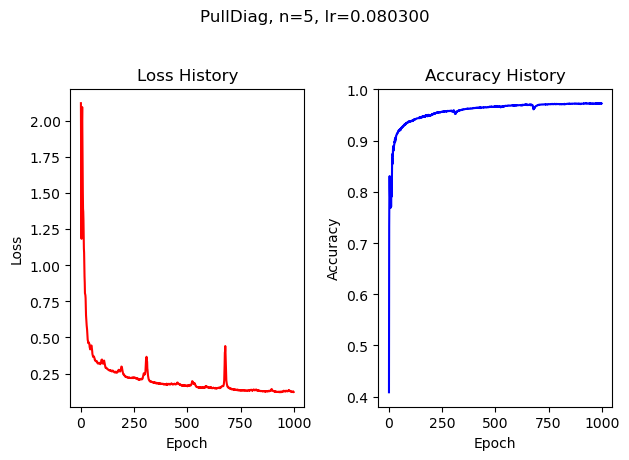

In [80]:
#均匀分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_shuffled()

#均匀分布数据
Diag_l0, Diag_a0 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.0803,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [00:41<00:00, 24.03it/s, accuracy=85.8800000000%, epoch=1000, loss=0.1465709820]


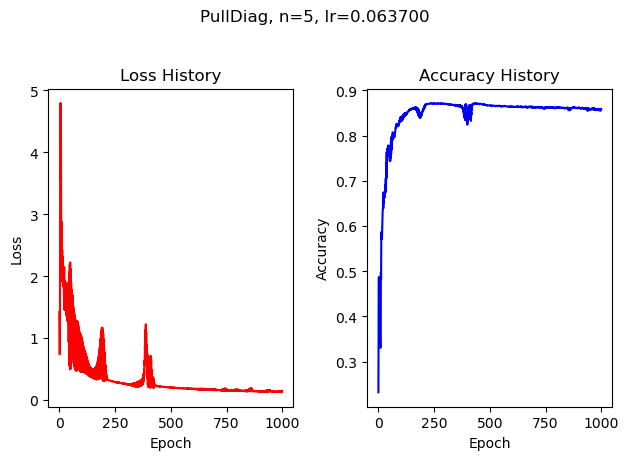

In [81]:
#大异质性分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

#大异质性数据
Diag_l1, Diag_a1 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.0637,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [00:41<00:00, 24.01it/s, accuracy=95.0500000000%, epoch=1000, loss=0.1559100389]


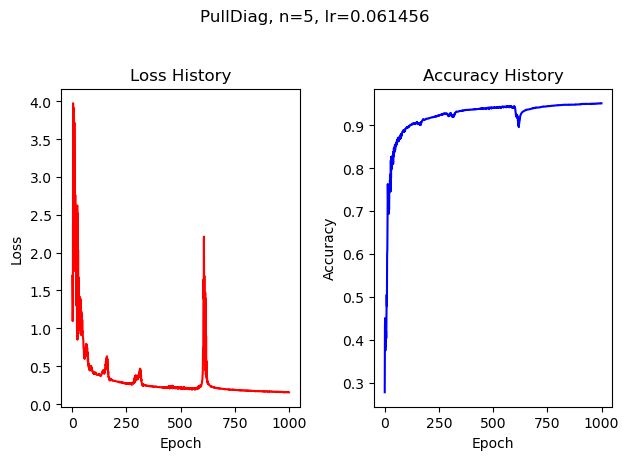

In [82]:
#混合分布数据 
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_mix(alpha=0.01,seed=53)

#混合分布数据
Diag_l2, Diag_a2 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.061456,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

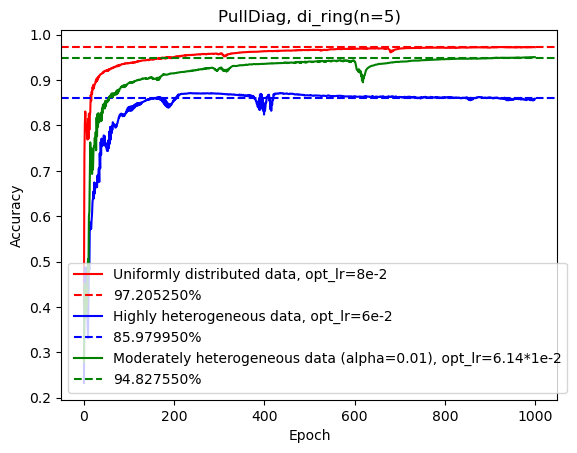

In [83]:
plt.plot(Diag_a0,color='r',label='Uniformly distributed data, opt_lr=8e-2')
number=np.mean(Diag_a0[800:])
plt.axhline(y=number, color='r', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Diag_a1,color='b',label='Highly heterogeneous data, opt_lr=6e-2')
number=np.mean(Diag_a1[800:])
plt.axhline(y=number, color='b', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Diag_a2,color='g',label='Moderately heterogeneous data (alpha=0.01), opt_lr=6.14*1e-2')
number=np.mean(Diag_a2[800:])
plt.axhline(y=number, color='g', linestyle='--', label=f'{100*number:4f}%')

plt.title("PullDiag, di_ring(n=5)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 【1】异质性观察
# 图2：pullsum在di_ring(n=5)+三种不同异质性的表现
# 图3：pulldiag和pullsum都在di_ring(n=5)或者di_ring(n=10)+强异质性下的对比表现

pullsum在di_ring(n=5)+三种不同异质性的表现

均匀分布的数据：lr_opt = 0.4

极大异质性分布的数据: lr_opt = 0.15
 
中等异质性分布的数据: lr_opt = 0.13

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.65it/s, accuracy=97.5300000000%, epoch=1000, loss=0.0991986543]


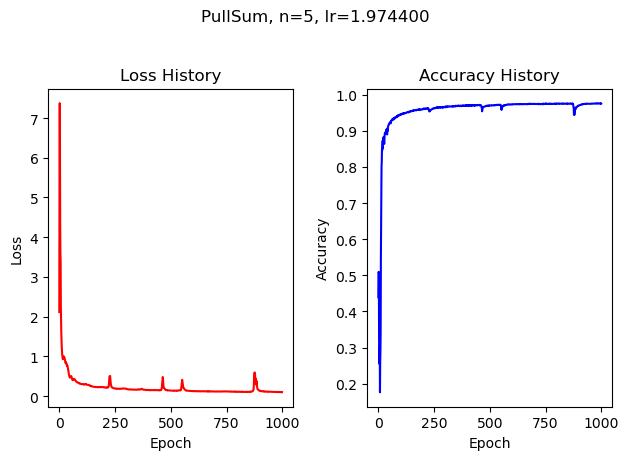

In [88]:
#均匀分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_shuffled()

Sum_l0, Sum_a0 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.39488,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [00:43<00:00, 22.81it/s, accuracy=87.3300000000%, epoch=1000, loss=0.1126680978]


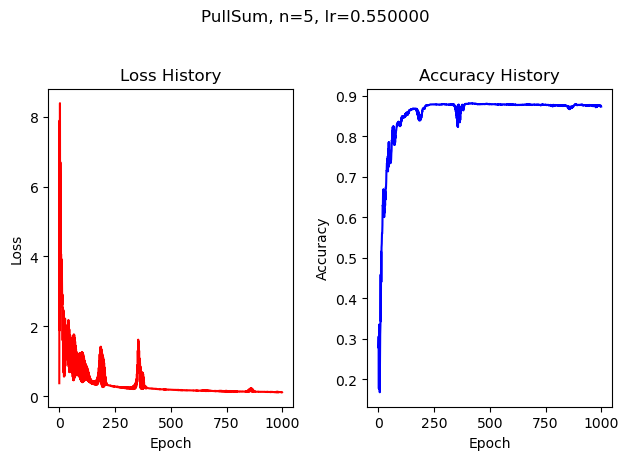

In [100]:
#大异质性分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

Sum_l1, Sum_a1 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.11,#0.14534766737788476,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s, accuracy=95.1600000000%, epoch=1000, loss=0.1619347170]


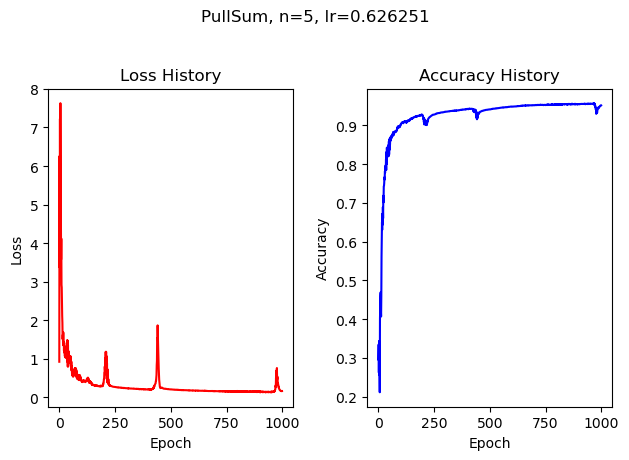

In [96]:
#混合分布数据 
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_mix(alpha=0.01,seed=53)

Sum_l2, Sum_a2 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.12525017337506775,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

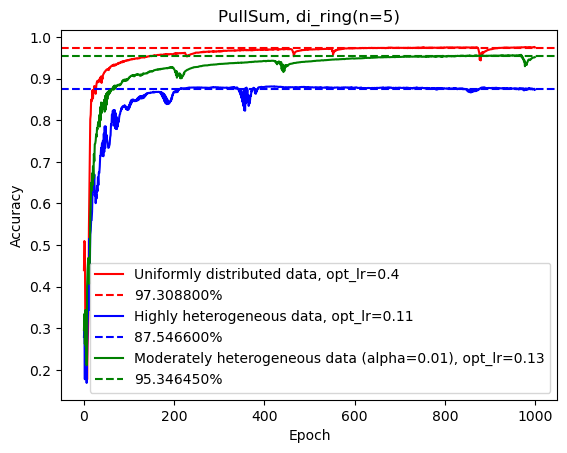

In [102]:
plt.plot(Sum_a0,color='r',label='Uniformly distributed data, opt_lr=0.4')
number=np.mean(Sum_a0[800:])
plt.axhline(y=number, color='r', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Sum_a1,color='b',label='Highly heterogeneous data, opt_lr=0.11')
number=np.mean(Sum_a1[800:])
plt.axhline(y=number, color='b', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Sum_a2,color='g',label='Moderately heterogeneous data (alpha=0.01), opt_lr=0.13')
number=np.mean(Sum_a2[800:])
plt.axhline(y=number, color='g', linestyle='--', label=f'{100*number:4f}%')

plt.title("PullSum, di_ring(n=5)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [95]:
def objective(trial):
    # 缩小 lr 的搜索范围，在已找到的最佳值附近搜索
    lr = trial.suggest_loguniform('lr',1e-4 ,1)

    try:
        Sum_l0, Sum_a0 = train_PullSum(
            n=n,
            A=A,
            B=B,
            model_class=MNISTClassifier_2layer_2,
            seed_for_model=49,
            criterion_class=nn.CrossEntropyLoss,
            epochs=100,
            lr=lr,
            X_train_data=h_data,
            y_train_data=y_data,
            X_test_data=X_test,
            y_test_data=y_test,
            compute_accuracy=compute_accuracy_with_average_model,
            show_graph=False
        )

        # 检查 FROZEN_l1 是否包含 inf 或 nan
        if np.isnan(Sum_l0).any() or np.isinf(Sum_l0).any():
            print(f"Trial failed due to inf/nan in loss. lr: {lr}")
            return -np.inf  # 返回一个非常低的值

        # 返回最终的准确率
        return Sum_a0[-1]

    except Exception as e:
        print(f"Trial failed with exception: {e}")
        return -np.inf  # 若发生异常，返回一个非常低的值

# 创建一个优化器并使用缩小后的搜索空间进行优化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f"Best parameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

[I 2024-09-11 09:48:19,125] A new study created in memory with name: no-name-360e72da-c231-4b6f-9359-d29313d46fc4
/tmp/ipykernel_2534908/1319633961.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr',1e-4 ,1)
Training Progress: 100%|██████████| 100/100 [00:04<00:00, 23.05it/s, accuracy=43.4400000000%, epoch=100, loss=2.0137010336]
[I 2024-09-11 09:48:23,521] Trial 0 finished with value: 0.4344 and parameters: {'lr': 0.00016427585219425374}. Best is trial 0 with value: 0.4344.
Training Progress: 100%|██████████| 100/100 [00:04<00:00, 23.40it/s, accuracy=89.5500000000%, epoch=100, loss=0.4140704125]
[I 2024-09-11 09:48:27,833] Trial 1 finished with value: 0.8955 and parameters: {'lr': 0.19443296668524687}. Best is trial 1 with value: 0.8955.
Training Progress: 100%|██████████| 100/100 [00:04<00:

Best parameters: {'lr': 0.12525017337506775}
Best accuracy: 0.9022
